In [54]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [56]:
from google.colab import files
files.upload()  # Upload the kaggle.json file

Saving kaggle (1).json to kaggle (1) (1).json


{'kaggle (1) (1).json': b'{"username":"ayoubdammak","key":"f577957f3391f727259f0e1278eec258"}'}

In [57]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [58]:
!kaggle datasets download -d emmarex/plantdisease
!unzip plantdisease.zip -d plantdisease

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
plantdisease.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  plantdisease.zip
replace plantdisease/PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [60]:
!kaggle models download -m ayoubdammak/mobilenet/Keras/default/1

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


# **Importation des bibliothèques**

In [61]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os
import kagglehub
import shutil
from sklearn.model_selection import train_test_split

In [66]:
# Download latest version
base_path = '/content/plantdisease/PlantVillage'

In [67]:
# Chemins pour train, valid et test
train_dir = '/kaggle/working/train'
val_dir = '/kaggle/working/valid'
test_dir = '/kaggle/working/test'

In [68]:
# Création des dossiers
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [69]:
# Parcourir chaque classe
for class_name in os.listdir(base_path):
    class_path = os.path.join(base_path, class_name)
    if os.path.isdir(class_path):
        # Lister les images dans la classe
        images = os.listdir(class_path)

        # Diviser les données en train, valid, test
        train_images, temp_images = train_test_split(images, test_size=0.2, random_state=42)
        val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

        # Créer les sous-dossiers pour chaque classe
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        # Copier les images dans les dossiers correspondants
        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name))

        for img in val_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_name))

        for img in test_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name))

# **Prétraitement des données**

**Génération de données**

In [70]:
# Générateurs de données
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

**Chargement des images**

In [71]:
# Charger les images
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 16504 images belonging to 16 classes.
Found 2064 images belonging to 16 classes.
Found 2070 images belonging to 16 classes.


**Chargement de MobileNetV2**

In [75]:
# Charger MobileNetV2

base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

In [76]:
# Geler les premières couches
base_model.trainable = False

# **Ajout des couches personnalisées**

In [77]:
# Ajouter des couches personnalisées
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(train_data.num_classes, activation='softmax')  # Adapté au nombre de classes
])

# **Compilation du modèle**

In [78]:
# Compiler le modèle
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# **Entraînement du modèle**

In [79]:
# Entraîner le modèle
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=val_data.samples // val_data.batch_size
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


515/515 ━━━━━━━━━━━━━━━━━━━━ 219s 397ms/step - accuracy: 0.5819 - loss: 1.3400 - val_accuracy: 0.8442 - val_loss: 0.4772
Epoch 2/10
  1/515 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - accuracy: 0.8125 - loss: 0.6717

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


515/515 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8125 - loss: 0.6717 - val_accuracy: 0.8125 - val_loss: 0.4811
Epoch 3/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 200s 383ms/step - accuracy: 0.7892 - loss: 0.6398 - val_accuracy: 0.8521 - val_loss: 0.4467
Epoch 4/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 63us/step - accuracy: 0.8125 - loss: 0.5040 - val_accuracy: 0.8125 - val_loss: 0.4391
Epoch 5/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 200s 380ms/step - accuracy: 0.8139 - loss: 0.5510 - val_accuracy: 0.8618 - val_loss: 0.4064
Epoch 6/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 68us/step - accuracy: 0.7812 - loss: 0.6421 - val_accuracy: 1.0000 - val_loss: 0.1404
Epoch 7/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 200s 374ms/step - accuracy: 0.8319 - loss: 0.4915 - val_accuracy: 0.8721 - val_loss: 0.3698
Epoch 8/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 69us/step - accuracy: 0.9062 - loss: 0.3780 - val_accuracy: 0.9375 - val_loss: 0.1427
Epoch 9/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 197s 377ms/step - accuracy: 0.8427 - loss: 0.4623 - val_accu

# **Traçage des courbes d'accuracy**

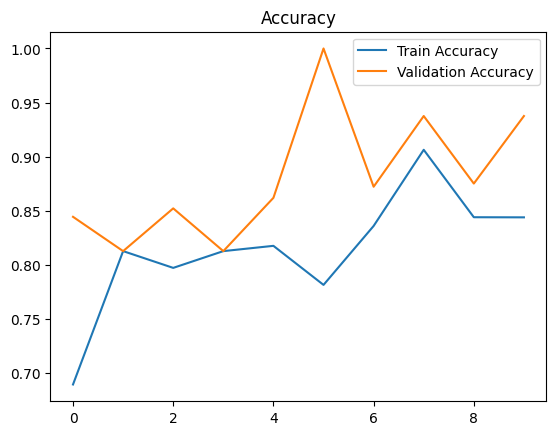

In [80]:
# Visualiser les courbes d'accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

# **Traçage des courbes de perte**

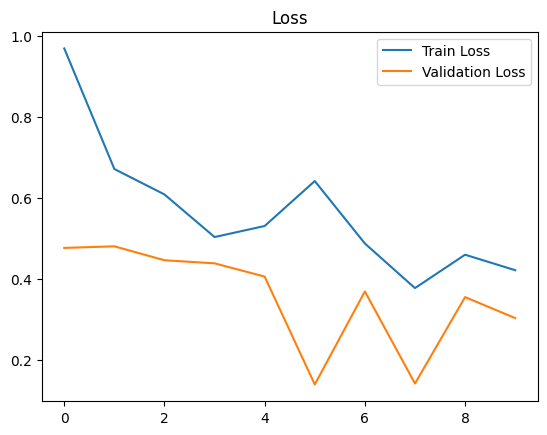

In [81]:
# Visualiser les courbes de perte
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

# **Fine Tuning**

In [82]:
# Débloquer certaines couches pour le fine-tuning
base_model.trainable = True
for layer in base_model.layers[:100]:  # Geler les premières couches
    layer.trainable = False

# Recompiler avec un taux d'apprentissage plus faible
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Réentraînement avec fine-tuning
history_finetune = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=val_data.samples // val_data.batch_size
)

Epoch 1/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 235s 411ms/step - accuracy: 0.6073 - loss: 1.4091 - val_accuracy: 0.8740 - val_loss: 0.3760
Epoch 2/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9062 - loss: 0.3623 - val_accuracy: 0.8125 - val_loss: 0.5557
Epoch 3/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 238s 388ms/step - accuracy: 0.8123 - loss: 0.5603 - val_accuracy: 0.8804 - val_loss: 0.3779
Epoch 4/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 73us/step - accuracy: 0.8125 - loss: 0.4799 - val_accuracy: 0.8750 - val_loss: 0.1890
Epoch 5/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 205s 393ms/step - accuracy: 0.8517 - loss: 0.4437 - val_accuracy: 0.8940 - val_loss: 0.3204


# **Evaluation du modèle**

In [83]:
# Évaluer le modèle
test_loss, test_acc = model.evaluate(test_data)
print(f'Test Accuracy: {test_acc}')
print(f'Test Loss: {test_loss}')

65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.8962 - loss: 0.2945
Test Accuracy: 0.8932366967201233
Test Loss: 0.31946638226509094


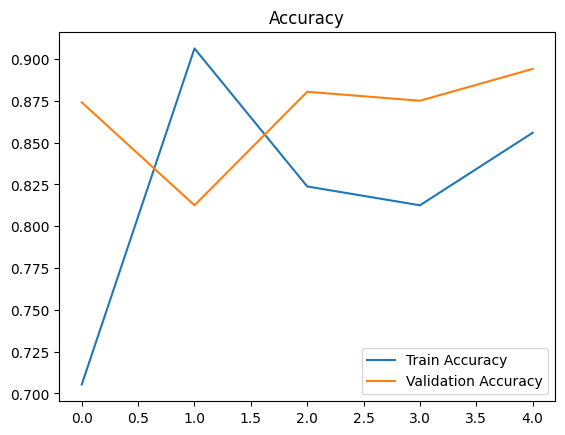

In [86]:
# Visualiser les courbes d'accuracy
plt.plot(history_finetune.history['accuracy'], label='Train Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [90]:
from tensorflow.keras.preprocessing import image

# Chemin vers une image de test
img_path = '/kaggle/working/test/Potato___healthy/22322780-95b4-4b45-b626-26b22965d55e___RS_HL 1880.JPG'

# Préparer l'image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Faire une prédiction
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions)
class_labels = list(train_data.class_indices.keys())

print(f"Predicted class: {class_labels[predicted_class]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted class: Potato___healthy


# **Préparer le modèle TensorFlow Lite**

In [91]:
import tensorflow as tf

# Convertir le modèle en TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # Ou utilisez `from_saved_model` si le modèle est enregistré
tflite_model = converter.convert()

# Sauvegarder le modèle TFLite
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp3msj5zfd'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_308')
Output Type:
  TensorSpec(shape=(None, 16), dtype=tf.float32, name=None)
Captures:
  135742747294912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135742747625952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135742747626128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135742747626480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135742747625424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135742747632992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135742747631936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135742747634576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135742747624368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135742747632464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135742747